In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Set random seed for reproducibility
np.random.seed(42)

# 2

In [38]:
def analytical_barrier_option(S0, K, B, T, r, sigma):
    """
    Calculate the analytical price of an up-and-out barrier call option.
    
    Parameters:
    S0: Initial stock price
    K: Strike price
    B: Barrier level (B > K)
    T: Time to maturity
    r: Risk-free rate
    sigma: Volatility
    """
    # If S0 >= B, option is knocked out immediately
    if S0 >= B:
        return 0
    
    # Define the delta functions according to the assignment
    def delta(z, tau, sign=1):  # sign=1 for +, sign=-1 for -
        return (np.log(z) + (r + sign * 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    
    # Term 1
    term1 = S0 * (norm.cdf(delta(S0/K, T, 1)) - norm.cdf(delta(S0/B, T, 1)))
    
    # Term 2
    term2 = -S0 * (B/S0)**(1 + 2*r/sigma**2) * (norm.cdf(delta(B**2/(K*S0), T, 1)) - norm.cdf(delta(B/S0, T, 1)))
    
    # Term 3
    term3 = -K * np.exp(-r*T) * (norm.cdf(delta(S0/K, T, -1)) - norm.cdf(delta(S0/B, T, -1)))
    
    # Term 4
    term4 = K * np.exp(-r*T) * (S0/B)**(1 - 2*r/sigma**2) * (norm.cdf(delta(B**2/(K*S0), T, -1)) - norm.cdf(delta(B/S0, T, -1)))
    
    return max(0, term1 + term2 + term3 + term4)

def monte_carlo_barrier_option(S0, K, B, T, r, sigma, n_paths=10000, n_steps=252, apply_correction=True):
    """Monte Carlo simulation for up-and-out barrier call option"""
    dt = T / n_steps
    
    # Apply continuity correction if requested
    B_adj = B
    if apply_correction:
        # Correction factor for discrete monitoring
        beta1 = 0.5826  # As given in the assignment
        B_adj = B * np.exp(beta1 * sigma * np.sqrt(T / n_steps))
    
    # Initialize asset price paths
    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    
    # Simulate price paths
    for t in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, n_paths)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    # Check for barrier hits along each path
    max_prices = np.maximum.accumulate(S, axis=1)
    barrier_hit = max_prices >= B_adj
    
    # Calculate payoff for each path - only if barrier never hit
    payoffs = np.maximum(S[:, -1] - K, 0) * (~barrier_hit[:, -1])
    
    # Discount payoffs to present value
    option_price = np.exp(-r * T) * payoffs.mean()
    option_se = np.exp(-r * T) * payoffs.std() / np.sqrt(n_paths)
    
    return option_price, option_se

Analytical price: 3.669940
Monte Carlo price (with correction): 4.344454 (SE: 0.070850)
Monte Carlo price (no correction): 4.045903 (SE: 0.067641)
Steps: 50, With correction: 5.105045, No correction: 4.497319
Steps: 100, With correction: 4.671101, No correction: 4.176961
Steps: 200, With correction: 4.386442, No correction: 4.000496
Steps: 500, With correction: 4.165645, No correction: 3.883875
Steps: 1000, With correction: 4.061439, No correction: 3.786278


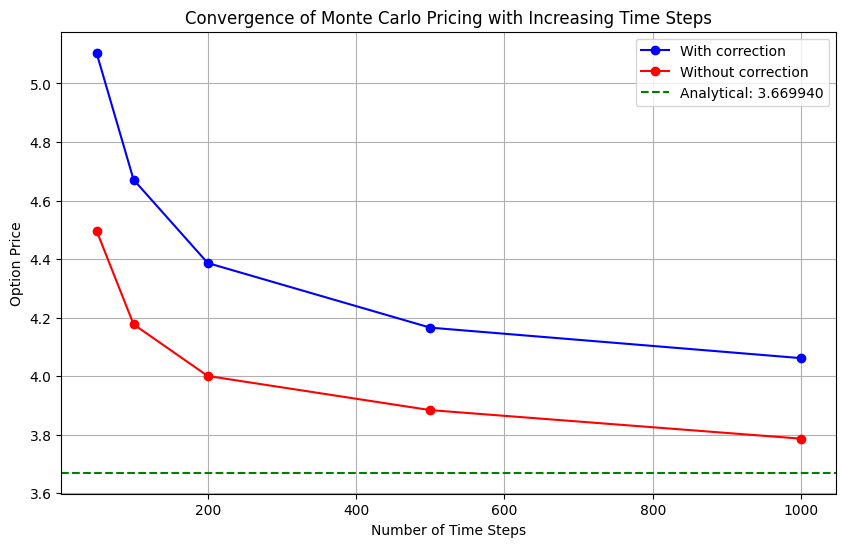

In [39]:
# Set parameters
S0 = 100      # Initial stock price
K = 90        # Strike price
B = 120       # Barrier level
T = 1.0       # Time to maturity (1 year)
r = 0.05      # Risk-free rate (5%)
sigma = 0.2   # Volatility (20%)

# Calculate analytical price
analytical_price = analytical_barrier_option(S0, K, B, T, r, sigma)
print(f"Analytical price: {analytical_price:.6f}")

# Run Monte Carlo simulation (with barrier correction)
mc_price_corr, mc_se_corr = monte_carlo_barrier_option(
    S0, K, B, T, r, sigma, n_paths=10000, n_steps=252, apply_correction=True
)
print(f"Monte Carlo price (with correction): {mc_price_corr:.6f} (SE: {mc_se_corr:.6f})")

# Run Monte Carlo simulation (without barrier correction)
mc_price_no_corr, mc_se_no_corr = monte_carlo_barrier_option(
    S0, K, B, T, r, sigma, n_paths=10000, n_steps=252, apply_correction=False
)
print(f"Monte Carlo price (no correction): {mc_price_no_corr:.6f} (SE: {mc_se_no_corr:.6f})")

# Study the convergence with different time steps
step_counts = [50, 100, 200, 500, 1000]
mc_prices_corr = []
mc_prices_no_corr = []

for n_steps in step_counts:
    price_corr, _ = monte_carlo_barrier_option(
        S0, K, B, T, r, sigma, n_paths=10000, n_steps=n_steps, apply_correction=True
    )
    price_no_corr, _ = monte_carlo_barrier_option(
        S0, K, B, T, r, sigma, n_paths=10000, n_steps=n_steps, apply_correction=False
    )
    mc_prices_corr.append(price_corr)
    mc_prices_no_corr.append(price_no_corr)
    
    print(f"Steps: {n_steps}, With correction: {price_corr:.6f}, No correction: {price_no_corr:.6f}")

# Plot convergence results
plt.figure(figsize=(10, 6))
plt.plot(step_counts, mc_prices_corr, 'bo-', label='With correction')
plt.plot(step_counts, mc_prices_no_corr, 'ro-', label='Without correction')
plt.axhline(y=analytical_price, color='g', linestyle='--', label=f'Analytical: {analytical_price:.6f}')
plt.xlabel('Number of Time Steps')
plt.ylabel('Option Price')
plt.title('Convergence of Monte Carlo Pricing with Increasing Time Steps')
plt.legend()
plt.grid(True)
plt.show()

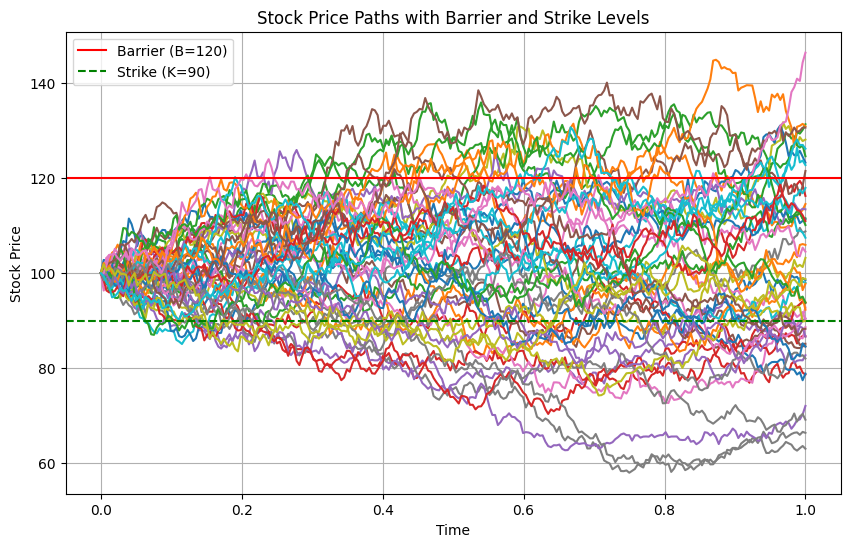

In [40]:
# Plot sample price paths
plt.figure(figsize=(10, 6))
n_sample_paths = 50
n_steps = 252
dt = T / n_steps
time_points = np.linspace(0, T, n_steps + 1)

# Generate paths
S = np.zeros((n_sample_paths, n_steps + 1))
S[:, 0] = S0

for i in range(n_sample_paths):
    Z = np.random.normal(0, 1, n_steps)
    for t in range(1, n_steps + 1):
        S[i, t] = S[i, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t-1])

# Plot paths
for i in range(n_sample_paths):
    plt.plot(time_points, S[i, :])

plt.axhline(y=B, color='r', linestyle='-', label=f'Barrier (B={B})')
plt.axhline(y=K, color='g', linestyle='--', label=f'Strike (K={K})')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Paths with Barrier and Strike Levels')
plt.grid(True)
plt.legend()
plt.show()

# 3

In [41]:
def implicit_barrier_option(S0, K, B, T, r, sigma, M=500, N=1000):
    """
    Implementation of implicit finite difference method for up-and-out barrier call option.
    
    Parameters:
    S0: Initial stock price
    K: Strike price
    B: Barrier level
    T: Time to maturity
    r: Risk-free rate
    sigma: Volatility
    M: Number of stock price steps (increased for better accuracy)
    N: Number of time steps (increased for better accuracy)
    
    Returns:
    option_price: Price of the barrier option
    S_grid: Stock price grid
    V: Option price matrix
    """
    # Create grid with finer resolution
    # Use a non-uniform grid with more points near S0 and B
    Smax = min(2*B, 3*S0)  # Maximum stock price
    S_grid = np.linspace(0, Smax, M+1)
    
    dt = T / N
    
    # Initialize option value grid
    V = np.zeros((M+1, N+1))
    
    # Terminal condition at t=T (option payoff)
    for i in range(M+1):
        S = S_grid[i]
        # Up-and-out barrier call option payoff
        if S < B:
            V[i, N] = max(0, S - K)
    
    # Calculate grid spacing
    dS = S_grid[1] - S_grid[0]
    
    # Time-stepping (backward in time)
    for j in range(N-1, -1, -1):
        # Initialize the tridiagonal system
        A_diag = np.zeros(M+1)
        A_upper = np.zeros(M)
        A_lower = np.zeros(M)
        rhs = np.zeros(M+1)
        
        # Boundary conditions
        V[0, j] = 0  # Option value at S=0
        
        # Find barrier index (S ≥ B)
        barrier_idx = np.searchsorted(S_grid, B)
        V[barrier_idx:, j] = 0  # Option value at or above barrier
        
        # Set up the system for interior points (0 < S < B)
        for i in range(1, barrier_idx):
            S = S_grid[i]
            
            # Calculate PDE coefficients
            alpha = 0.5 * sigma**2 * S**2 / dS**2
            beta = r * S / dS
            
            # Set up matrix coefficients for implicit scheme
            A_diag[i] = 1 + 2*alpha*dt + r*dt
            A_upper[i] = -alpha*dt - 0.5*beta*dt
            A_lower[i-1] = -alpha*dt + 0.5*beta*dt
            
            # Right-hand side
            rhs[i] = V[i, j+1]
        
        # Solve the tridiagonal system for interior points
        # First convert to tridiagonal form for efficient solver
        A = sparse.diags([A_lower, A_diag[1:barrier_idx], A_upper[1:barrier_idx-1]], 
                         [-1, 0, 1], shape=(barrier_idx-1, barrier_idx-1))
        
        # Solve for interior points
        interior_solution = spsolve(A, rhs[1:barrier_idx])
        V[1:barrier_idx, j] = interior_solution
    
    # Interpolate to get the price at S0
    idx = np.searchsorted(S_grid, S0) - 1
    idx = max(0, min(idx, M-1))  # Ensure within bounds
    
    # Linear interpolation
    if idx < M:
        weight = (S0 - S_grid[idx]) / (S_grid[idx+1] - S_grid[idx])
        option_price = (1-weight) * V[idx, 0] + weight * V[idx+1, 0]
    else:
        option_price = V[idx, 0]
    
    return option_price, S_grid, V

def compute_delta(S_grid, V, method='central'):
    """
    Compute option delta using finite differences.
    
    Parameters:
    S_grid: Stock price grid
    V: Option price matrix
    method: Differencing method ('central', 'forward', or 'backward')
    
    Returns:
    delta: Option delta for each stock price
    """
    delta = np.zeros_like(S_grid)
    dS = S_grid[1] - S_grid[0]
    
    if method == 'central':
        # Interior points
        for i in range(1, len(S_grid)-1):
            delta[i] = (V[i+1, 0] - V[i-1, 0]) / (2 * dS)
        
        # Boundary points
        delta[0] = (V[1, 0] - V[0, 0]) / dS
        delta[-1] = (V[-1, 0] - V[-2, 0]) / dS
    
    elif method == 'forward':
        # All points except the last one
        for i in range(len(S_grid)-1):
            delta[i] = (V[i+1, 0] - V[i, 0]) / dS
        
        # Last point
        delta[-1] = delta[-2]
    
    elif method == 'backward':
        # First point
        delta[0] = delta[1]
        
        # All other points
        for i in range(1, len(S_grid)):
            delta[i] = (V[i, 0] - V[i-1, 0]) / dS
    
    return delta

In [42]:
# Parameters
S0 = 100
K = 90
B = 120
T = 1.0
r = 0.05
sigma = 0.2

# 1. Calculate option price using implicit method
price, S_grid, V = implicit_barrier_option(S0, K, B, T, r, sigma, M=100, N=100)
print(f"Barrier option price at S0={S0}: {price:.6f}")

Barrier option price at S0=100: 0.772037


/var/folders/ns/50vdztlx2dqg0087kwf82gvh0000gn/T/ipykernel_15903/2955757646.py:77: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  interior_solution = spsolve(A, rhs[1:barrier_idx])


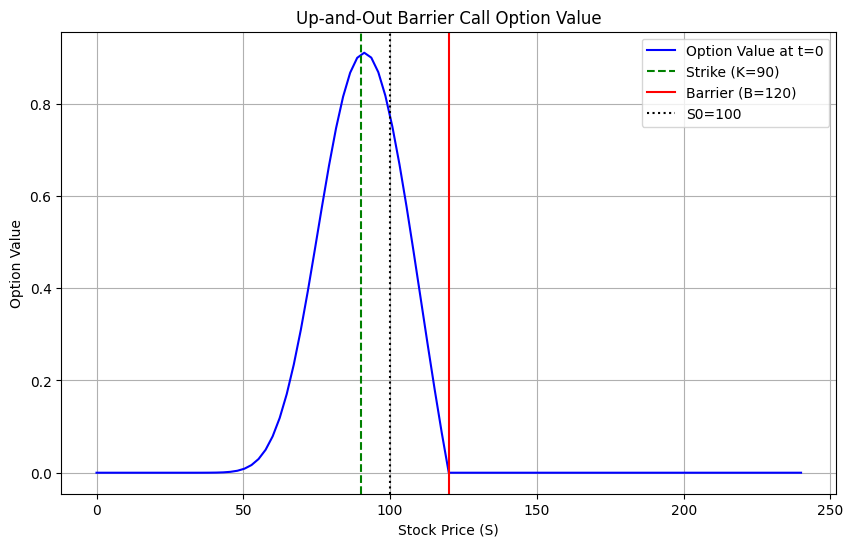

In [43]:
# 2. Calculate delta
delta = compute_delta(S_grid, V)

# 3. Plot option value at t=0
plt.figure(figsize=(10, 6))
plt.plot(S_grid, V[:, 0], 'b-', label='Option Value at t=0')
plt.axvline(x=K, color='g', linestyle='--', label=f'Strike (K={K})')
plt.axvline(x=B, color='r', linestyle='-', label=f'Barrier (B={B})')
plt.axvline(x=S0, color='k', linestyle=':', label=f'S0={S0}')
plt.xlabel('Stock Price (S)')
plt.ylabel('Option Value')
plt.title('Up-and-Out Barrier Call Option Value')
plt.grid(True)
plt.legend()
plt.show()

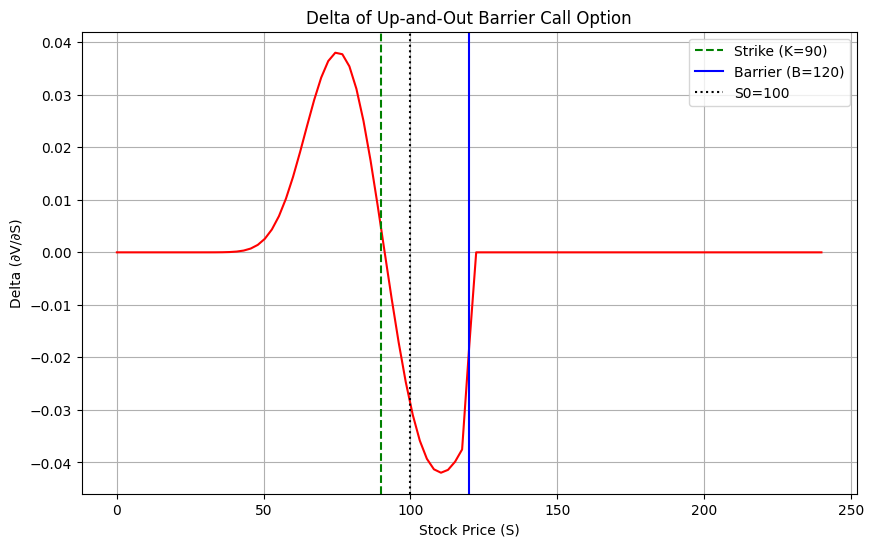

In [44]:
# 4. Plot delta
plt.figure(figsize=(10, 6))
plt.plot(S_grid, delta, 'r-')
plt.axvline(x=K, color='g', linestyle='--', label=f'Strike (K={K})')
plt.axvline(x=B, color='b', linestyle='-', label=f'Barrier (B={B})')
plt.axvline(x=S0, color='k', linestyle=':', label=f'S0={S0}')
plt.xlabel('Stock Price (S)')
plt.ylabel('Delta (∂V/∂S)')
plt.title('Delta of Up-and-Out Barrier Call Option')
plt.grid(True)
plt.legend()
plt.show()

/var/folders/ns/50vdztlx2dqg0087kwf82gvh0000gn/T/ipykernel_15903/2955757646.py:77: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  interior_solution = spsolve(A, rhs[1:barrier_idx])


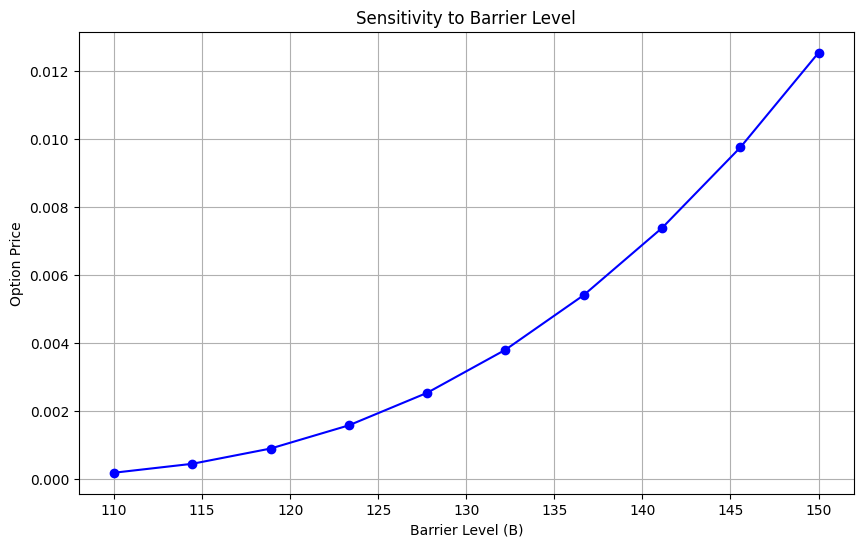

In [48]:
# 5. Sensitivity to barrier level
barrier_levels = np.linspace(110, 150, 10)
prices = []

for barrier in barrier_levels:
    price, _, _ = implicit_barrier_option(S0, K, barrier, T, r, sigma)
    prices.append(price)

plt.figure(figsize=(10, 6))
plt.plot(barrier_levels, prices, 'bo-')
plt.xlabel('Barrier Level (B)')
plt.ylabel('Option Price')
plt.title('Sensitivity to Barrier Level')
plt.grid(True)
plt.show()

/var/folders/ns/50vdztlx2dqg0087kwf82gvh0000gn/T/ipykernel_15903/2955757646.py:77: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  interior_solution = spsolve(A, rhs[1:barrier_idx])


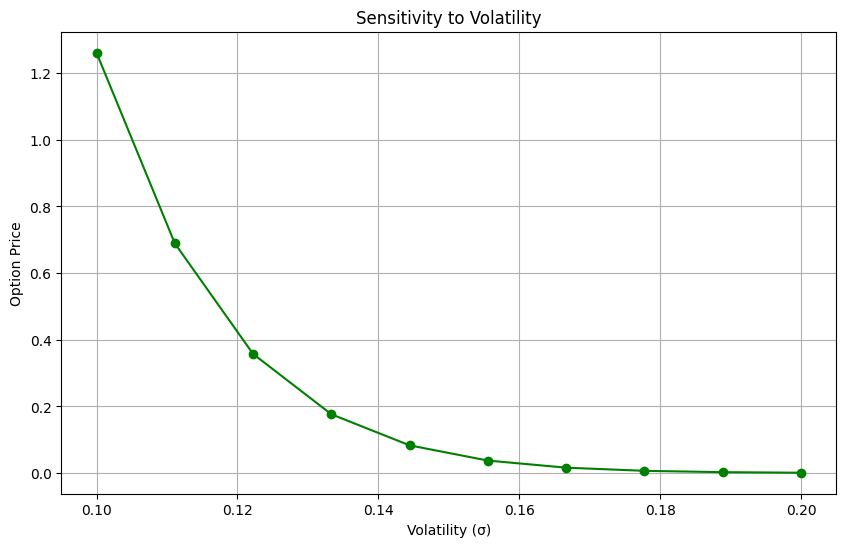

In [51]:
# 6. Sensitivity to volatility
volatilities = np.linspace(0.1, 0.2, 10)
prices_vol = []

for vol in volatilities:
    price, _, _ = implicit_barrier_option(S0, K, B, T, r, vol)
    prices_vol.append(price)

plt.figure(figsize=(10, 6))
plt.plot(volatilities, prices_vol, 'go-')
plt.xlabel('Volatility (σ)')
plt.ylabel('Option Price')
plt.title('Sensitivity to Volatility')
plt.grid(True)
plt.show()

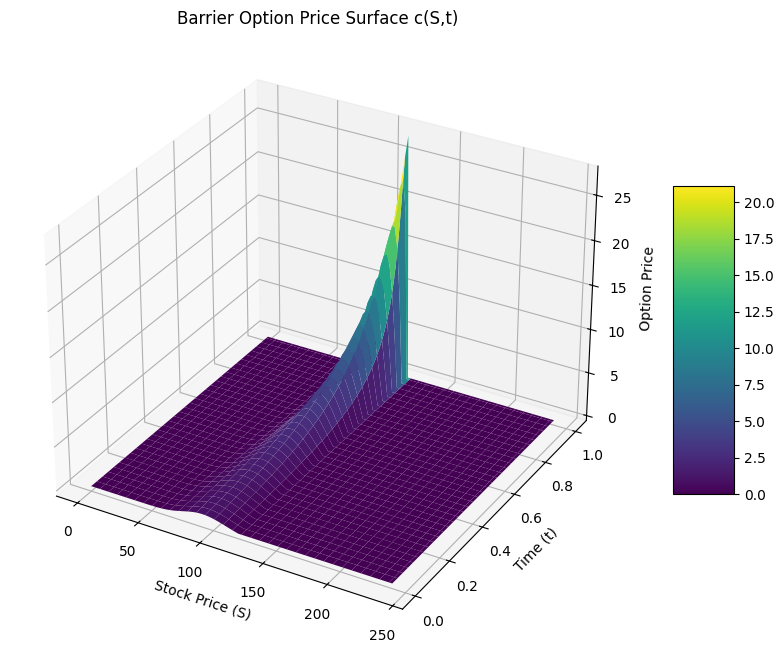

In [ ]:
# 7. Plot option surface
t_grid = np.linspace(0, T, V.shape[1])
S_mesh, t_mesh = np.meshgrid(S_grid, t_grid)

# Transpose V for plotting
V_plot = V.T
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(S_mesh, t_mesh, V_plot, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Option Price')
ax.set_title('Barrier Option Price Surface c(S,t)')

plt.show()